## **Bibliotecas**

In [8]:
# Bibliotecas para importação e análise de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from datetime import datetime, timedelta

In [ ]:
# Bibliotecas para ML/Deep Learning


## **Importação dos dados**

In [11]:
# Carregamento das bases de dados para o Pandas
path_combs = r'C:\Users\Colaborador\Desktop\TCC\Datasets'
path_dolar = r'C:\Users\Colaborador\Desktop\TCC\USD_BRLdata.csv'

### PREÇOS DE COMBUSTÍVEIS

files = glob.glob(path_combs + '/*.csv')
many_dfs = [pd.read_csv(file, sep=';') for file in files]
df_combs = pd.concat(many_dfs, ignore_index=False)

### COTAÇÃO DO DÓLAR

df_dolar = pd.read_csv(path_dolar, sep=',')

In [12]:
display(df_combs.head())
display(df_dolar.head())

,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,GASOLINA,03/01/2022,"6,99",NaN,R$ / litro,VIBRA ENERGIA
1,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,ETANOL,03/01/2022,"5,99",NaN,R$ / litro,VIBRA ENERGIA
2,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,DIESEL,03/01/2022,"6,09",NaN,R$ / litro,VIBRA ENERGIA
3,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,GASOLINA ADITIVADA,03/01/2022,"7,05",NaN,R$ / litro,VIBRA ENERGIA
4,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,DIESEL S10,03/01/2022,"6,12",NaN,R$ / litro,VIBRA ENERGIA


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,28.12.2023,"4,8521","4,8323","4,8714","4,8175",NaN,"0,53%"
1,27.12.2023,"4,8267","4,8107","4,8408","4,8018",NaN,"0,26%"
2,26.12.2023,"4,8140","4,8513","4,8614","4,8135",NaN,"-0,92%"
3,22.12.2023,"4,8585","4,8865","4,8908","4,8481",NaN,"-0,53%"
4,21.12.2023,"4,8844","4,9146","4,9146","4,8633",NaN,"-0,65%"


## **Informações gerais acerca dos dados**

In [13]:
# Informações gerais acerca dos dados
print(f"Dados sobre combustíveis:\nQuantidade de linhas: {df_combs.shape[0]}\nQuantidade de colunas: {df_combs.shape[1]}\n")
display(df_combs.dtypes)
print('------'*10)
print(f"Dados sobre cotação do Dólar (USD):\nQuantidade de linhas: {df_dolar.shape[0]}\nQuantidade de colunas: {df_dolar.shape[1]}\n")
display(df_dolar.dtypes)


Dados sobre combustíveis:
Quantidade de linhas: 1811502
Quantidade de colunas: 16



Regiao - Sigla        object
Estado - Sigla        object
Municipio             object
Revenda               object
CNPJ da Revenda       object
Nome da Rua           object
Numero Rua            object
Complemento           object
Bairro                object
Cep                   object
Produto               object
Data da Coleta        object
Valor de Venda        object
Valor de Compra      float64
Unidade de Medida     object
Bandeira              object
dtype: object

------------------------------------------------------------
Dados sobre cotação do Dólar (USD):
Quantidade de linhas: 515
Quantidade de colunas: 7



Data        object
Último      object
Abertura    object
Máxima      object
Mínima      object
Vol.        object
Var%        object
dtype: object

In [17]:
print("Quantidade de valores nulos em cada coluna - Dataset COMBUSTÍVEIS:")
display(df_combs.isnull().sum())
print('------'*10)
print("Quantidade de valores nulos em cada coluna - Dataset DÓLAR:")
display(df_dolar.isnull().sum())


Quantidade de valores nulos em cada coluna - Dataset COMBUSTÍVEIS:


Regiao - Sigla             0
Estado - Sigla             0
Municipio                  0
Revenda                    0
CNPJ da Revenda            0
Nome da Rua                0
Numero Rua               636
Complemento          1407881
Bairro                  4016
Cep                        0
Produto                    0
Data da Coleta             0
Valor de Venda             0
Valor de Compra      1811502
Unidade de Medida          0
Bandeira                   0
dtype: int64

------------------------------------------------------------
Quantidade de valores nulos em cada coluna - Dataset DÓLAR:


Data          0
Último        0
Abertura      0
Máxima        0
Mínima        0
Vol.        243
Var%          0
dtype: int64

## **Tratamento dos dados**

In [47]:
# Filtrando pelos casos apenas de MG e eliminando os casos de GNV (Gás Natural Veicular)
c1 = df_combs['Estado - Sigla'] == 'MG'
c2 = df_combs['Produto'] != 'GNV'
df_fuels = df_combs[c1 & c2]

In [48]:
# Remoção de colunas indesejadas e mudança nos nomes das restantes - Dataset COMBUSTÍVEIS
non_relevant = ['Regiao - Sigla', 'Revenda', 'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro', 'Valor de Compra', 'Unidade de Medida']
new_name = {'Estado - Sigla': 'estado',
            'Municipio': 'municipio',
            'Cep': 'cep',
            'Produto' : 'tipo_comb',
            'Data da Coleta' : 'data',
            'Valor de Venda' : 'preco',
            'Bandeira' : 'bandeira'}
df_fuels = df_fuels.rename(columns=new_name)\
     .drop(non_relevant, axis=1)

# Remoção de colunas indesejadas e mudança nos nomes das restantes - Dataset DÓLAR
non_relevant = ['Abertura', 'Mínima', 'Vol.', 'Máxima']
new_name = {'Data': 'data',
            'Último': 'ultimo',
            'Var%': 'variacao'}
df_dolar = df_dolar.rename(columns=new_name)\
     .drop(non_relevant, axis=1)

In [49]:
print(f"Quantidade de linhas do Dataframe: {df_fuels.shape[0]}\nQuantidade de colunas do Dataframe: {df_fuels.shape[1]}\n---- Dataframe COMBUSTÍVEL ----")
display(df_fuels.dtypes)
print("---- Dataframe DÓLAR ----")
display(df_dolar.dtypes)

Quantidade de linhas do Dataframe: 185224
Quantidade de colunas do Dataframe: 7
---- Dataframe COMBUSTÍVEL ----


estado       object
municipio    object
cep          object
tipo_comb    object
data         object
preco        object
bandeira     object
dtype: object

---- Dataframe DÓLAR ----


data        object
ultimo      object
variacao    object
dtype: object

In [59]:
# Conversão de tipagem dos dados das colunas - Dataset COMBUSTÍVEIS
#cvcols = ['estado', 'municipio', 'cep', 'tipo_comb', 'bandeira']
#df_fuels[cvcols] = df_fuels[cvcols].astype("string")
#df_fuels['preco'] = df_fuels['preco'].str.replace(',', '.').astype("float")
#df_fuels['data'] = pd.to_datetime(df_fuels['data'], format='%d/%m/%Y')

# Conversão de tipagem dos dados das colunas - Dataset COMBUSTÍVEIS

df_dolar['ultimo'] = df_dolar['ultimo'].str.replace(',', '.').astype("float")
df_dolar['variacao'] = df_dolar['variacao'].str.replace(',', '.').str.replace('%', '').astype("float")
df_dolar['data'] = pd.to_datetime(df_dolar['data'], format='%d/%m/%Y')

AttributeError: Can only use .str accessor with string values!

In [54]:
df_dolar.dtypes

data        object
ultimo      object
variacao    object
dtype: object

In [19]:
df_fuels.describe()

,data,preco
count,185224,185224.000000
mean,2023-01-02 11:36:07.028030976,5.597880
min,2022-01-03 00:00:00,2.890000
25%,2022-06-15 00:00:00,4.909750
50%,2023-01-23 00:00:00,5.570000
75%,2023-07-18 00:00:00,6.390000
max,2023-12-29 00:00:00,8.990000
std,NaN,1.183145


## TESTES

In [19]:
df_fuels['preco_medio'] = df_fuels.groupby(['data', 'tipo_comb'])['preco'].transform('mean')


In [27]:
df_uniq = df_fuels.drop_duplicates(subset=['data', 'preco_medio'])
df_uniq

,estado,municipio,cep,tipo_comb,data,preco,bandeira,preco_medio
254,MG,CONSELHEIRO LAFAIETE,36400-000,GASOLINA,2022-01-03,6.89,BRANCA,7.010568
255,MG,CONSELHEIRO LAFAIETE,36400-000,ETANOL,2022-01-03,5.19,BRANCA,5.322093
256,MG,CONSELHEIRO LAFAIETE,36400-000,DIESEL S10,2022-01-03,5.30,BRANCA,5.408939
259,MG,CONSELHEIRO LAFAIETE,36400-000,DIESEL,2022-01-03,5.32,BRANCA,5.330222
260,MG,CONSELHEIRO LAFAIETE,36400-000,GASOLINA ADITIVADA,2022-01-03,6.97,BRANCA,7.133400
...,...,...,...,...,...,...,...,...
455629,MG,CONTAGEM,32017-390,GASOLINA ADITIVADA,2023-12-29,5.25,IPIRANGA,5.758621
455630,MG,CONTAGEM,32017-390,DIESEL,2023-12-29,5.48,IPIRANGA,5.874545
455631,MG,CONTAGEM,32017-390,DIESEL S10,2023-12-29,5.58,IPIRANGA,6.015000
455632,MG,CONTAGEM,32017-390,ETANOL,2023-12-29,3.16,IPIRANGA,3.445366


In [32]:
combs = df_uniq['tipo_comb'].unique()
dfs = {}
for k in combs:
    dfs[k] = df_uniq[df_uniq['tipo_comb']==k].copy()

In [40]:
dfs['ETANOL']

,estado,municipio,cep,tipo_comb,data,preco,bandeira,preco_medio
255,MG,CONSELHEIRO LAFAIETE,36400-000,ETANOL,2022-01-03,5.19,BRANCA,5.322093
4666,MG,ALFENAS,37132-393,ETANOL,2022-01-04,5.49,BRANCA,5.330513
10605,MG,BARBACENA,36200-372,ETANOL,2022-01-05,4.93,TOTALENERGIES,5.159517
15944,MG,CONSELHEIRO LAFAIETE,36400-000,ETANOL,2022-01-06,5.29,VIBRA ENERGIA,5.242297
18956,MG,CONSELHEIRO LAFAIETE,36401-174,ETANOL,2022-01-10,5.22,BRANCA,5.322340
...,...,...,...,...,...,...,...,...
455477,MG,ALFENAS,37130-027,ETANOL,2023-12-27,3.39,BRANCA,3.482689
455485,MG,ALFENAS,37135-232,ETANOL,2023-12-28,3.23,BRANCA,3.520120
455492,MG,BARBACENA,36202-370,ETANOL,2023-12-26,3.39,RAIZEN,3.501087
455496,MG,BARBACENA,36200-078,ETANOL,2023-12-25,3.39,RAIZEN,3.401935


In [41]:
etano = dfs['ETANOL'].set_index('data')

In [43]:
etano = etano.resample('B').ffill()

In [47]:
etano.reset_index(inplace=True)
etano

,data,estado,municipio,cep,tipo_comb,preco,bandeira,preco_medio
0,2022-01-03,MG,CONSELHEIRO LAFAIETE,36400-000,ETANOL,5.19,BRANCA,5.322093
1,2022-01-04,MG,ALFENAS,37132-393,ETANOL,5.49,BRANCA,5.330513
2,2022-01-05,MG,BARBACENA,36200-372,ETANOL,4.93,TOTALENERGIES,5.159517
3,2022-01-06,MG,CONSELHEIRO LAFAIETE,36400-000,ETANOL,5.29,VIBRA ENERGIA,5.242297
4,2022-01-07,MG,CONSELHEIRO LAFAIETE,36400-000,ETANOL,5.29,VIBRA ENERGIA,5.242297
...,...,...,...,...,...,...,...,...
515,2023-12-25,MG,BARBACENA,36200-078,ETANOL,3.39,RAIZEN,3.401935
516,2023-12-26,MG,BARBACENA,36202-370,ETANOL,3.39,RAIZEN,3.501087
517,2023-12-27,MG,ALFENAS,37130-027,ETANOL,3.39,BRANCA,3.482689
518,2023-12-28,MG,ALFENAS,37135-232,ETANOL,3.23,BRANCA,3.520120


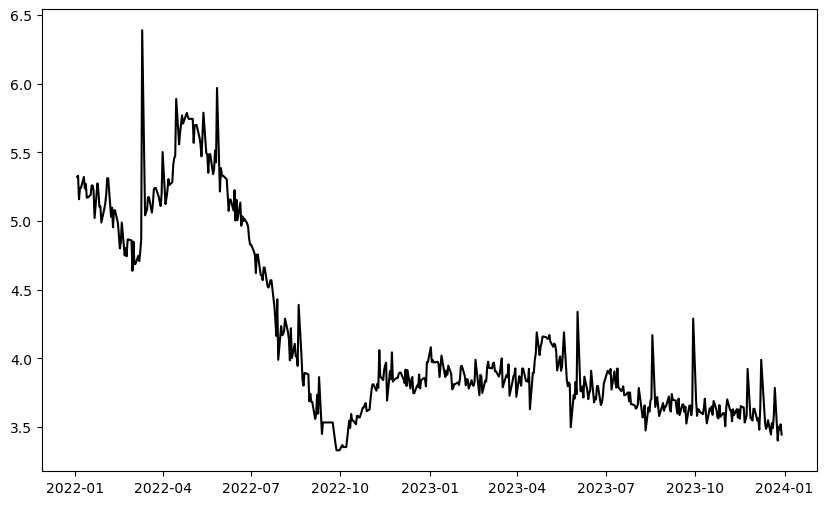

In [49]:
#mask = df_fuels['tipo_comb'] == 'GASOLINA'
plt.figure(figsize=(10,6))
plt.plot(etano['data'], etano['preco_medio'], c='black')

### Continuação

In [15]:
df_fuels.sample(5)

,estado,municipio,cep,tipo_comb,data,preco,bandeira
528345,MG,UNAI,38610-000,DIESEL,2022-06-30,7.79,IPIRANGA
238598,MG,BELO HORIZONTE,30870-100,DIESEL S10,2022-09-26,6.99,VIBRA ENERGIA
215969,MG,UBA,36500-000,GASOLINA ADITIVADA,2022-03-21,7.59,BRANCA
87141,MG,OLIVEIRA,35540-000,DIESEL,2023-02-09,6.09,BRANCA
387898,MG,BETIM,32689-898,GASOLINA ADITIVADA,2022-05-17,7.69,IPIRANGA


In [16]:
plt.figure(figsize=(10, 6))
plt.bar(df_fuels['tipo_comb'], df_fuels['preco'], color='skyblue')
plt.xlabel('Fuel Type')
plt.ylabel('Price ($)')
plt.title('Fuel Prices')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001ADF7F1F4C0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001AD8B98E840> (for post_execute):


KeyboardInterrupt: 

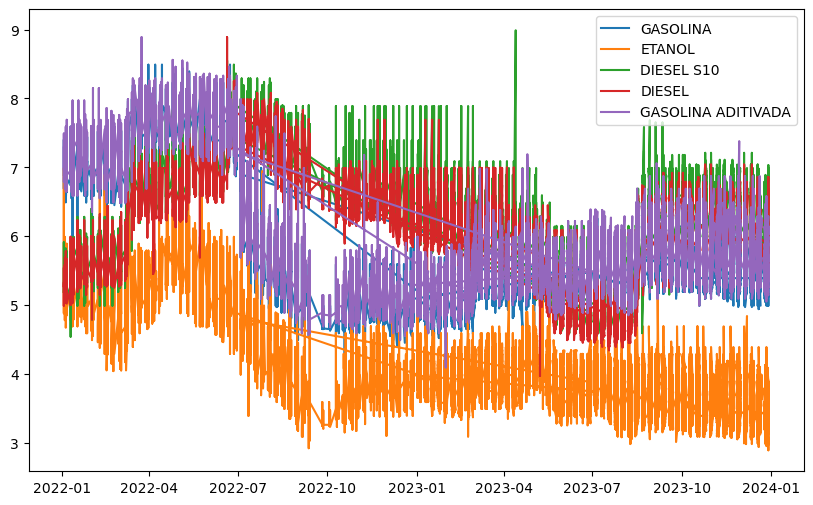

In [18]:
plt.figure(figsize=(10, 6))
for tipo in df_fuels['tipo_comb'].unique():
    data = df_fuels[df_fuels['tipo_comb'] == tipo]
    plt.plot(data['data'], data['preco'], label=tipo)
plt.legend()

In [ ]:
combustiveis = df_fuels['tipo_comb'].unique()
fig, axes = plt.subplots(nrows=len(combustiveis), ncols=1, figsize=(10, 6), sharex=True)
for i, tipo in enumerate(combustiveis):
    data = df_fuels[df_fuels['tipo_comb'] == tipo]
    axes[i].plot(data['data'], data['preco'], label=tipo)
    axes[i].set_ylabel('Preço (R$)')
    axes[i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.xlabel('Data')

In [ ]:
df_fuels['preco_medio'] = df_fuels.groupby(['data', 'tipo_comb'])['preco'].transform('mean')

In [ ]:
mask = df_fuels['tipo_comb'] == 'GASOLINA'
plt.figure(figsize=(10,6))
plt.plot(df_fuels.loc[mask, 'data'], df_fuels.loc[mask, 'preco_medio'], c='black', linestyle='dotted')

In [419]:
a = df_fuels[df_fuels['tipo_comb'] == 'GASOLINA']
a.shape

(45925, 8)

### TESTES

In [430]:
#start_date = datetime(2022, 1, 1)
#end_date = datetime(2023, 11, 30)
#data_ini = start

#a.loc[(a['data']>='2022-01-01') & (a['data'] <= '2022-01-31')]['data'].value_counts().sort_index()

#while data_ini <= end:
#    data_fin = (data_ini + timedelta(days=31)).replace(day=1) - timedelta(days=1)
#    a.loc[(a['data']>=data_ini) & (a['data'] <= data_fin)]['data'].value_counts().sort_index()
#    data_ini = (data_fin + timedelta(days=1)).replace(day=1)

#a.loc[(a['data']>=data_inicio) & (a['data'] <= data_fim)]['data'].value_counts().sort_index()

In [437]:
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 11, 30)

periodo = pd.date_range(start=start_date, end=end_date, freq='D')
datas_df = pd.DataFrame({'data': periodo})

In [438]:
datas_faltantes = datas_df.merge(df_fuels, on='data', how='left', suffixes=['', '_'], indicator=True)

In [444]:
a = datas_faltantes['data'].loc[datas_faltantes['_merge'] == 'left_only']

In [450]:
a.tolist()

[Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-07 00:00:00'),
 Timestamp('2022-01-08 00:00:00'),
 Timestamp('2022-01-09 00:00:00'),
 Timestamp('2022-01-14 00:00:00'),
 Timestamp('2022-01-15 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 Timestamp('2022-01-22 00:00:00'),
 Timestamp('2022-01-23 00:00:00'),
 Timestamp('2022-01-29 00:00:00'),
 Timestamp('2022-01-30 00:00:00'),
 Timestamp('2022-02-04 00:00:00'),
 Timestamp('2022-02-05 00:00:00'),
 Timestamp('2022-02-06 00:00:00'),
 Timestamp('2022-02-11 00:00:00'),
 Timestamp('2022-02-12 00:00:00'),
 Timestamp('2022-02-13 00:00:00'),
 Timestamp('2022-02-19 00:00:00'),
 Timestamp('2022-02-20 00:00:00'),
 Timestamp('2022-02-25 00:00:00'),
 Timestamp('2022-02-26 00:00:00'),
 Timestamp('2022-02-27 00:00:00'),
 Timestamp('2022-03-04 00:00:00'),
 Timestamp('2022-03-05 00:00:00'),
 Timestamp('2022-03-06 00:00:00'),
 Timestamp('2022-03-12 00:00:00'),
 Timestamp('2022-03-13 00:00:00'),
 Timestamp('2022-03-

In [442]:
a['data'].sort_values().unique()
#for i in a['data'].sort_values().unique():
#    print(i)

<DatetimeArray>
['2022-01-03 00:00:00', '2022-01-04 00:00:00', '2022-01-05 00:00:00',
 '2022-01-06 00:00:00', '2022-01-10 00:00:00', '2022-01-11 00:00:00',
 '2022-01-12 00:00:00', '2022-01-13 00:00:00', '2022-01-17 00:00:00',
 '2022-01-18 00:00:00',
 ...
 '2023-11-17 00:00:00', '2023-11-20 00:00:00', '2023-11-21 00:00:00',
 '2023-11-22 00:00:00', '2023-11-23 00:00:00', '2023-11-24 00:00:00',
 '2023-11-27 00:00:00', '2023-11-28 00:00:00', '2023-11-29 00:00:00',
 '2023-11-30 00:00:00']
Length: 450, dtype: datetime64[ns]

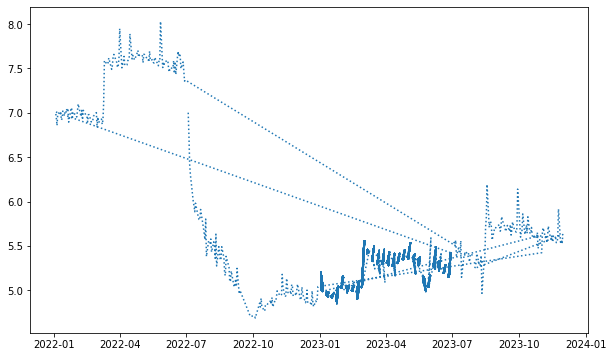

In [420]:
plt.figure(figsize=(10,6))
plt.plot(a['data'], a['preco_medio'], linestyle='dotted')

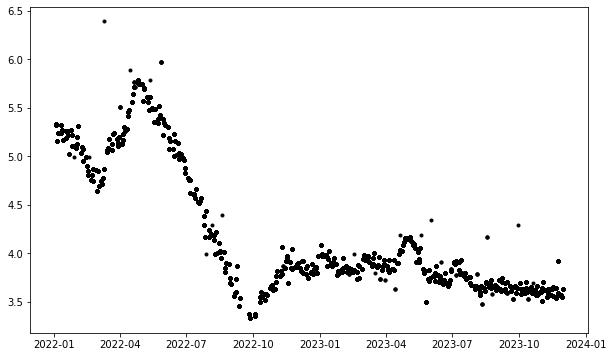

In [421]:
mask = df_fuels['tipo_comb'] == 'ETANOL'
plt.figure(figsize=(10,6))
plt.scatter(df_fuels.loc[mask, 'data'], df_fuels.loc[mask, 'preco_medio'], marker='.', c='black')

In [273]:
df_fuels.loc[mask, 'preco_medio']

13195    5.449348
13199    5.449348
13203    5.449348
13207    5.449348
13211    5.449348
           ...   
53079    3.763333
53081    3.763333
53084    3.763333
53087    3.763333
53090    3.763333
Name: preco_medio, Length: 4596, dtype: float64

Text(0.5, 32.99999999999995, 'Data')

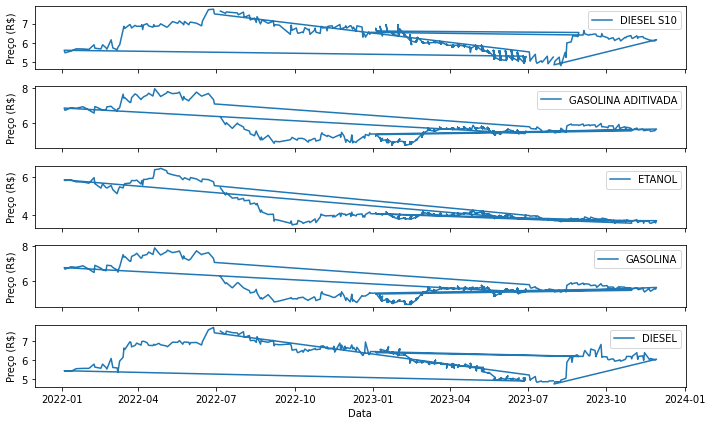

In [263]:
#combustiveis = df_fuels['tipo_comb'].unique()
#fig, axes = plt.subplots(nrows=len(combustiveis), ncols=1, figsize=(10, 6), sharex=True)
#for i, tipo in enumerate(combustiveis):
#    data = df_fuels[df_fuels['tipo_comb'] == tipo]
#    axes[i].plot(data['data'], data['preco_medio'], label=tipo)
#    axes[i].set_ylabel('Preço (R$)')
#    axes[i].legend()

#plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.xlabel('Data')